### Heart Attack Analysis & Prediction 

#### download a dataset from Kaggle

In [1]:
# install the Kaggle API client:
# !pip install kaggle\

# to ignore the warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# upload  Kaggle API key:
!mkdir -p ~/.kaggle
!echo '{"username":"ahmadsoliman94","key":"ffb7c90fc4521d202ca247af6493f9ad"}' > ~/.kaggle/kaggle.json

In [3]:
# download the dataset:
!kaggle datasets download -d rashikrahmanpritom/heart-attack-analysis-prediction-dataset

/bin/bash: kaggle: command not found


#### unizip the dataset

In [4]:
import zipfile

# Open the zip file
with zipfile.ZipFile("heart-attack-analysis-prediction-dataset.zip", "r") as zip_ref:
    # Extract all the contents of the zip file
    zip_ref.extractall("dataset/")

##### About the dataset: 
- Age : Age of the patient
- Sex : Sex of the patient
- exang: exercise induced angina (1 = yes; 0 = no)
- ca: number of major vessels (0-3)
- cp : Chest Pain type chest pain type:
* Value 1: typical angina
* Value 2: atypical angina
* Value 3: non-anginal pain
* Value 4: asymptomatic
- trtbps : resting blood pressure (in mm Hg)
- chol : cholestoral in mg/dl fetched via BMI sensor
- fbs : (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
- rest_ecg : resting electrocardiographic results:
* Value 0: normal
* Value 1: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
* Value 2: showing probable or definite left ventricular hypertrophy by Estes' criteria

* thalach : maximum heart rate achieved
* output : 0= less chance of heart attack 1= more chance of heart attack
#### In this notebook, various machine learning algorithms will be applied and try to predict the Heart Attack.

### Import the necessary libraries


In [5]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import randint

import xgboost as xgb
from sklearn.svm import SVC



from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, KFold,StratifiedKFold, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, RobustScaler
from sklearn.metrics import classification_report,ConfusionMatrixDisplay,confusion_matrix, plot_confusion_matrix

#### Load the data into a Pandas DataFrame

In [6]:
def load_data(path):
    dataframe = pd.read_csv(path)
    return dataframe

In [7]:
df_path = os.getcwd() + '/dataset/heart.csv'

In [8]:
df = load_data(os.getcwd() + '/dataset/heart.csv')

In [9]:
df.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


### Explore the data

In [10]:
'''
in this function i will use two medtods:
describe(): is used for calculating some statistical data like percentile, mean and std of the numerical values.
info(): this method prints information about a DataFrame including the index dtype and column dtypes, non-null values and memory usage.
'''

def explore_dataset(dataframe):
    display(dataframe.describe())
    print('\n\n')
    dataframe.info()

In [11]:
explore_dataset(df)

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       303 non-null    int64  
 1   sex       303 non-null    int64  
 2   cp        303 non-null    int64  
 3   trtbps    303 non-null    int64  
 4   chol      303 non-null    int64  
 5   fbs       303 non-null    int64  
 6   restecg   303 non-null    int64  
 7   thalachh  303 non-null    int64  
 8   exng      303 non-null    int64  
 9   oldpeak   303 non-null    float64
 10  slp       303 non-null    int64  
 11  caa       303 non-null    int64  
 12  thall     303 non-null    int64  
 13  output    303 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 33.3 KB


#### * of the outputs above we can observe, that there are no missing values and no object datatype. 

#### show the correlations between variables

In [12]:
'''
in this function we will: 
1. Compute the correlation matrix
2. Set up the matplotlib figure
3. Draw the heatmap 
'''

def show_corr(dataframe): 
    correlation = dataframe.corr()
    f, ax = plt.subplots(figsize=(11, 9))
    sns.heatmap(correlation,annot=True)
    return correlation

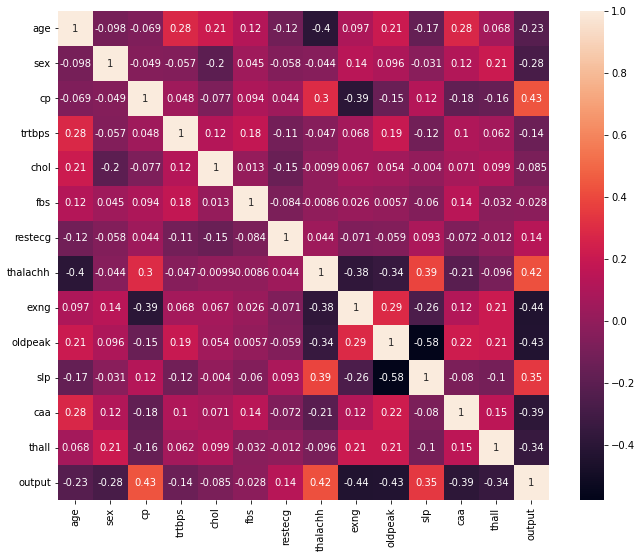

In [13]:
corr = show_corr(df)

In [14]:
# pairplot to visualize the relationships between variables and identify any trends or patterns in the data.
#sns.pairplot(df,hue='output')

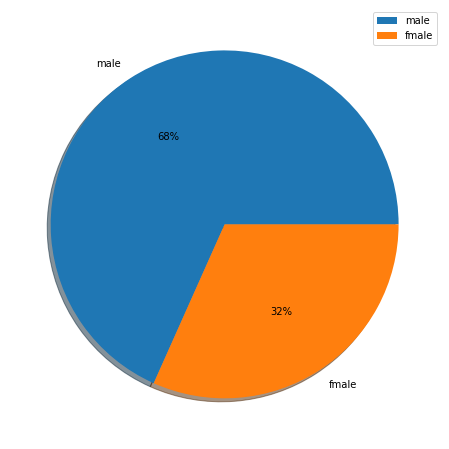

In [15]:
# to observe the sex of the patient
label = ['male','fmale']
data = df['sex'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(data,labels=label,autopct='%.0f%%',shadow=True,)
plt.legend()
plt.show()

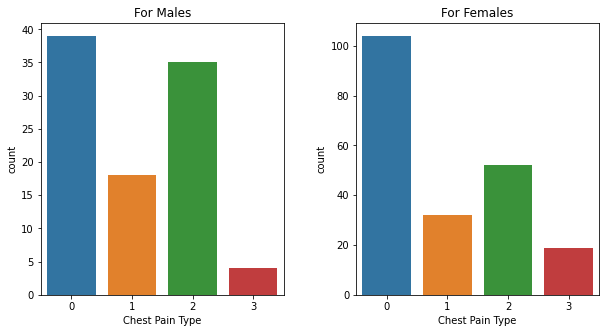

In [16]:
# Let's see how chest pain type varies according to gender.
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

sns.countplot(data=df[df['sex']==0], x='cp', ax=axs[0])
axs[0].set(title="For Males")
axs[0].set(xlabel="Chest Pain Type")
sns.countplot(data=df[df['sex']==1], x='cp', ax=axs[1])
axs[1].set(title="For Females")
axs[1].set(xlabel="Chest Pain Type")
# adjust the space between figures
plt.subplots_adjust(wspace=0.3, hspace=0.1)

plt.show()

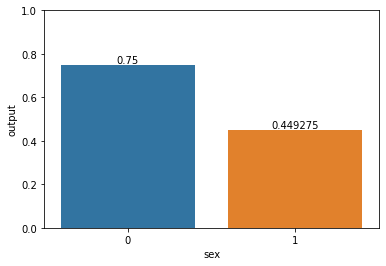

In [17]:
# observe the risk of heart attack according to gender.
fig, ax = plt.subplots()
sns.barplot(data=df, x='sex', y='output', estimator=np.mean, ci=None, ax=ax) # ci: Size of confidence intervals to draw around estimated values.
ax.bar_label(ax.containers[0])
ax.set_ylim((0, 1))

plt.show()

- Most males in this dataset are at risk of heart attack (75%). About half (44%) of females are at risk

### Check the outliers

Original DataFrame shape: (303, 14)




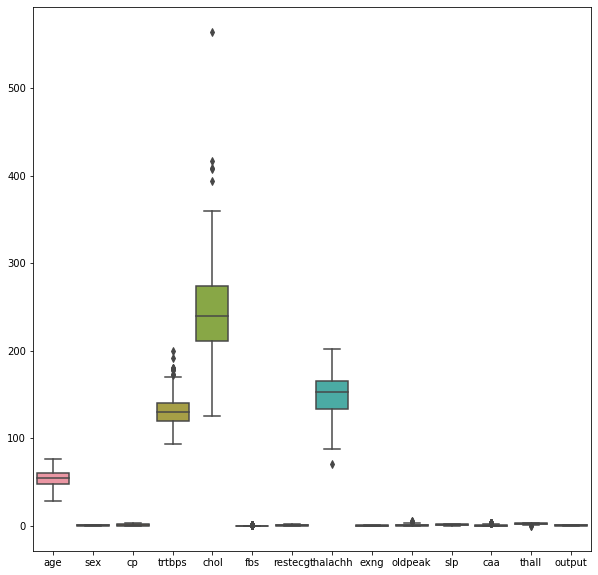

In [18]:
print(f"Original DataFrame shape: {df.shape}\n\n")

# Visualize the outliers
plt.figure(figsize=(10,10))
sns.boxplot(data=df)
plt.show()

In [19]:
'''
in this function i will try to detect outliers ,remove them then 
visualize the outliers  before and after removing them
'''

def remove_outliers(dataframe, columns):
    for column in columns:
        # Calculate the interquartile range (IQR) for the column
        Q1 = dataframe[column].quantile(0.25)
        Q3 = dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        
         # calculate the outlier cutoff
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)
        
        # calculate the lower and upper bound value
        print(f'column name: {column}')
        print('The IQR is',IQR)
        print('The lower bound value is', lower_range)
        print('The upper bound value is', upper_range)
        
        # Identify outliers
        df1 = dataframe[dataframe[column] > upper_range]
        df2 = dataframe[dataframe[column] < lower_range]
        outliers = df1.shape[0]+ df2.shape[0]
        print(f'Total number of outliers: {outliers}' )
        print('----------------------------------------------------------------------')
        
        # Remove rows that contain values that are lower than Q1 - 1.5 * IQR or greater than Q3 + 1.5 * IQR
        dataframe = dataframe[~((dataframe[column] < lower_range) | (dataframe[column] > upper_range))] # the tilde (~) can be used to negate a boolean condition when selecting rows.
        
    print(f"\n\nNew DataFrame shape: {dataframe.shape}\n\n")

    # Visualize the outliers
    plt.figure(figsize=(10,10))
    sns.boxplot(data=dataframe)
    plt.show()
        

    return dataframe

column name: age
The IQR is 13.5
The lower bound value is 27.25
The upper bound value is 81.25
Total number of outliers: 0
----------------------------------------------------------------------
column name: sex
The IQR is 1.0
The lower bound value is -1.5
The upper bound value is 2.5
Total number of outliers: 0
----------------------------------------------------------------------
column name: cp
The IQR is 2.0
The lower bound value is -3.0
The upper bound value is 5.0
Total number of outliers: 0
----------------------------------------------------------------------
column name: trtbps
The IQR is 20.0
The lower bound value is 90.0
The upper bound value is 170.0
Total number of outliers: 9
----------------------------------------------------------------------
column name: chol
The IQR is 62.75
The lower bound value is 116.875
The upper bound value is 367.875
Total number of outliers: 5
----------------------------------------------------------------------
column name: fbs
The IQR is 0.0

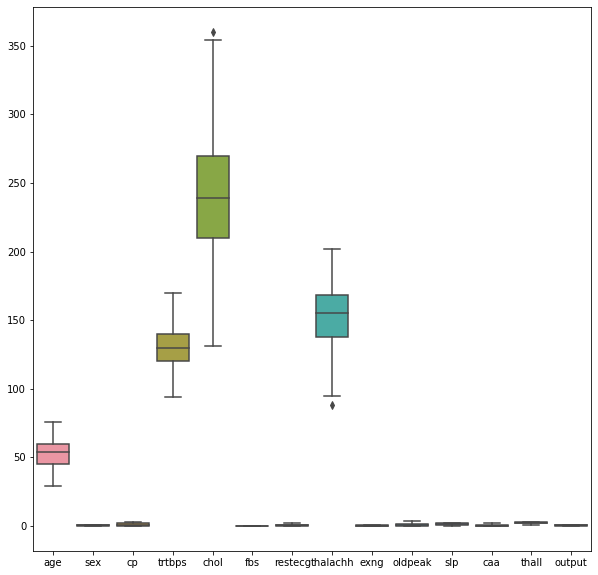

In [20]:
df_cleaned = remove_outliers(df, [column for column in df.columns])


### Check for duplicated rows

In [21]:
duplicated_rows = df_cleaned.duplicated(subset=df_cleaned.columns, keep=False)
# Print the duplicated rows
print(df_cleaned[duplicated_rows])

Empty DataFrame
Columns: [age, sex, cp, trtbps, chol, fbs, restecg, thalachh, exng, oldpeak, slp, caa, thall, output]
Index: []


In [22]:
df_cleaned.drop_duplicates(inplace=True)

#### Split the data into train and test

In [23]:
X = df_cleaned.drop('output', axis=1) # Whether to drop labels from the index (0 or 'index') or columns (1 or 'columns').
y = df_cleaned['output']

X.shape, y.shape

((228, 13), (228,))

### Feautre selection

In [24]:
''' try to select n top featres using random forest importance and 
cross-validation to evaluate the peformance of selected model then plot them '''  

def feature_selector(x,y,n_features=None):
    
    # Create a random forest classifier
    clf = RandomForestClassifier(random_state=48)
    
    # Train the classifier with the training data
    clf.fit(x, y)
    
    
     # Use SelectFromModel to select the top n features based on feature importance
    selector = SelectFromModel(clf, max_features=n_features,threshold=0.05)
    selector.fit(x, y)
    
    # Get the selected features as a boolean mask
    selected_features = selector.get_support()
    
    # Get the names of the selected features
    feature_names = x.columns[selected_features]
    
    # Use the selected features to transform the data
    X_selected = selector.transform(x)
    
    # Use cross-validation to evaluate the model with the selected features
    scores = cross_val_score(clf, X_selected, y, cv=5)

    
    '''
    Mean score: is the average of all the scores obtained during the cross-validation process.
    Standard deviation score: is a measure of the dispersion of the scores around the mean.
    
    - if the mean of the cross-validation scores is high and the standard deviation is low, 
    the model is performing well. 
    
    - if the mean is high but the standard deviation is also high,  
    the model is overfitting
    '''
    
    # Get the mean and standard deviation of the scores
    mean = np.mean(scores)
    std = np.std(scores)
    

                      
    # Plot the feature importances
    plt.figure(figsize=(10, 5))
    plt.barh(range(len(feature_names)), feature_names)
    plt.xlabel("Feature importance")
    plt.title(f"Mean score = {mean:.3f} +/- {std:.3f}")
    plt.show()
    
    return selected_features
       

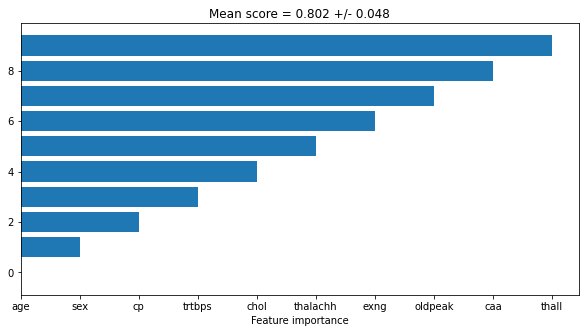

In [25]:
selected_features = feature_selector(X,y,n_features=13)

In [26]:
X_selected = X.iloc[:, selected_features]

In [27]:
X_selected.shape, y.shape

((228, 10), (228,))

In [28]:
'''
to split data and print the shape of them
'''
def split_data(x,y,test_size,random_state=None):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = test_size,random_state=random_state)
    print(f'Shape of X train: {x_train.shape}')
    print(f'Shape of y train: {y_train.shape}')
    print(f'Shape of X test: {x_test.shape}')
    print(f'Shape of y test: {y_test.shape}')
    return x_train, x_test, y_train, y_test

In [29]:
X_train, X_test, y_train, y_test = split_data(X_selected,y,test_size=0.2,random_state=0)

Shape of X train: (182, 10)
Shape of y train: (182,)
Shape of X test: (46, 10)
Shape of y test: (46,)


#### Selecting models

In [30]:
'''
in this function i will choose various classification algorthims then iset up pipeline for model and scaler. 
I will apply k-fold cross validation for data and trying to tuning the hyperparameters as well 
then evaluate the model peformance using accuracy_score.

'''

def build_model(x_train, y_train,x_test,y_test,model,scaler,hyperparameter,metric=''):
    
    # Set up the pipeline with the scaler and the model
    pipeline = Pipeline([
        ('scaler', scaler),
        ('model', model)
    ])

    # Set up the hyperparameter grid to search over
    param_grid = hyperparameter

    # Set up the K-fold cross-validator
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)

    # Set up the grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=kfold, scoring=metric)

    # Fit the grid search to the data
    grid_search.fit(x_train, y_train)

    # Print the best hyperparameters
    print("Best hyperparameters:", grid_search.best_params_)

    # Get the best model from the grid search
    best_model = grid_search.best_estimator_

    # Evaluate the model using the best hyperparameters
    model_prediction = best_model.predict(x_test)
    model_acc = accuracy_score(y_test, model_prediction)
    print(f"accuracy :{model_acc}\n" )
    
    # to print classification_report
    print(classification_report(y_test, model_prediction))
    
    return model_prediction, model_acc

### Let's try these following classifiers to make the machine learning model:

- Logistic Regression
- Support Vector Machine (linear kernel)
- k-Nearest Neighbors
- Decision Tree
- Random forest
- xg-boost

In [31]:
# Create a dictionary of classifiers
classifiers  = [

    # 1.
    {
     "name": 'Logistic Regression', 
     'model': LogisticRegression(), 
     'hyperparameters': 
        {
            'model__penalty':[None,'l2','l1'],
            'model__fit_intercept':[True,False]
             }
    
    },
    
    # 2. 
        {

     "name": "Support Vector Machine" , 
     'model': SVC(), 
     'hyperparameters': 
        {
    'model__kernel':['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
    'model__max_iter':[20,30,50,100,-1],
    'model__gamma': ['auto', 'scale']
             }
    
    },
    
    # 3. 
        {
     "name": 'k-Nearest Neighbors', 
     'model': KNeighborsClassifier(), 
     'hyperparameters': 
        {
           'model__n_neighbors':[5,6,7,8,9],
           'model__weights':['uniform','distance'],
           'model__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
             }
    
    },
    
    # 4. 
        {
     "name": 'Decision Tree', 
     'model':  DecisionTreeClassifier(), 
     'hyperparameters': 
        {
            'model__criterion':['gini', 'entropy', 'log_loss'],
            'model__splitter':['random', 'best'],
            'model__min_samples_split': [2,4,6,8],
            'model__max_leaf_nodes':[4,5,6,7]
             }
    
    },
    
        # 5. 
        {
     "name": 'Random forest', 
     'model': RandomForestClassifier(random_state=42), 
     'hyperparameters': 
        {
            'model__n_estimators':[100,200,300],
            'model__criterion':['gini','entropy'],
            'model__max_depth':[3,4,5,6,7,8,9],
            'model__bootstrap' : [True, False],
            'model__min_samples_split': [2,4,6,8]
             }
    
    },
    
    # 6. 
        {
     "name": 'xg-boost', 
     'model': xgb.XGBClassifier(objective = 'binary:logistic',random_state=42), 
     'hyperparameters': 
        {
              'model__n_estimators': [50,100,150, 300],
              'model__eta': [0.01, 0.002,0.0003,0.3],
              'model__subsample': [0.3, 0.01,0.5],
              'model__max_depth': [3, 4, 5, 6, 7, 8, 9],
              'model__colsample_bytree': [0.5, 0.4,0.6],
              'model__min_child_weight': [1, 2, 3, 4]
             }
    
    }
    
] 

# define scaler
scaler = RobustScaler()

# define metric
metric = 'accuracy'

Classifier: Logistic Regression:

Best hyperparameters: {'model__fit_intercept': True, 'model__penalty': 'l2'}
accuracy :0.8478260869565217

              precision    recall  f1-score   support

           0       0.84      0.88      0.86        24
           1       0.86      0.82      0.84        22

    accuracy                           0.85        46
   macro avg       0.85      0.85      0.85        46
weighted avg       0.85      0.85      0.85        46

----------------------------------------------------------------

Classifier: Support Vector Machine:

Best hyperparameters: {'model__gamma': 'auto', 'model__kernel': 'linear', 'model__max_iter': -1}
accuracy :0.8043478260869565

              precision    recall  f1-score   support

           0       0.83      0.79      0.81        24
           1       0.78      0.82      0.80        22

    accuracy                           0.80        46
   macro avg       0.80      0.80      0.80        46
weighted avg       0.81      0

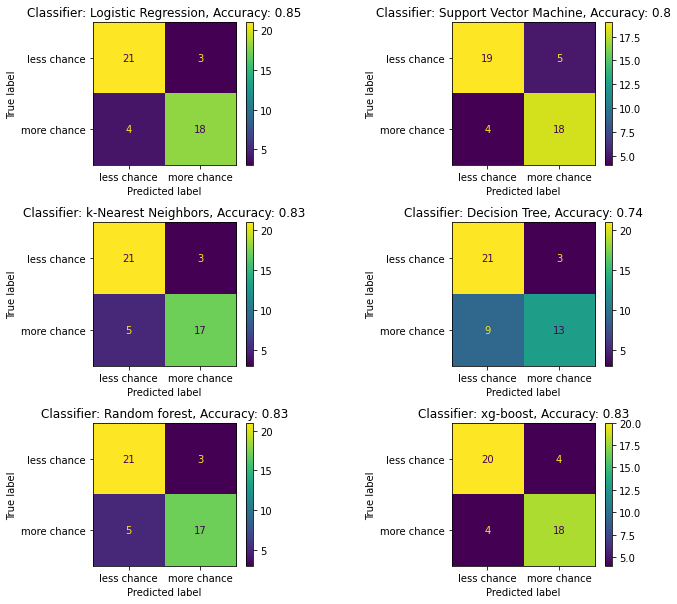

In [32]:
accuracies,  predictions = [], []

# Create a figure with 3 rows and 2 columns
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2,figsize=(10, 10))

# iterate over the list of classifiers
for i, classifier in enumerate(classifiers):
    name = classifier['name']
    model = classifier['model']
    hyperparameter = classifier['hyperparameters']
    print (f"Classifier: {name}:\n")
    predection, accuracy = build_model(X_train, y_train,X_test,y_test,model=model,scaler=scaler,hyperparameter=hyperparameter,metric=metric)
    accuracies.append(accuracy)
    predictions.append(predection)
    print('----------------------------------------------------------------\n')
    
    # compute confusion matrix
    cm = confusion_matrix(y_test, predection)
    
    # Get the corresponding subplot
    ax = eval(f"ax{i+1}")
    
    # create ConfusionMatrixDisplay object
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                                  display_labels=['less chance','more chance'])
    # plot the confusion matrix on the specified axis 
    disp.plot(ax=ax)
    
    # set the title of the plot
    ax.set_title("Classifier: {}, Accuracy: {}".format(name,round(accuracy, 2)))
    
# adjust the space between figures
plt.subplots_adjust(wspace=0.8, hspace=0.4)

# show the figure
plt.show()

##### Store all predictions acuracies into Dataframe then visulize them using bar-plot

In [38]:
# return classifiers name

classifier_name = []
for classifier in classifiers:
    classifier_name.append(classifier['name'])

In [39]:
classifier_name

['Logistic Regression',
 'Support Vector Machine',
 'k-Nearest Neighbors',
 'Decision Tree',
 'Random forest',
 'xg-boost']

In [40]:
df = pd.DataFrame({'Accuraccy': accuracies}, index=classifier_name)

In [41]:
df.sort_values(by='Accuraccy',inplace=True,ascending=True)
df

,Accuraccy
Decision Tree,0.739130
Support Vector Machine,0.804348
k-Nearest Neighbors,0.826087
Random forest,0.826087
xg-boost,0.826087
Logistic Regression,0.847826


<AxesSubplot:xlabel='Accuraccy'>

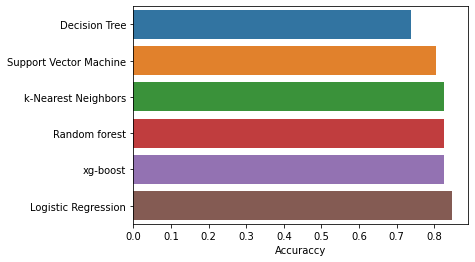

In [42]:
# plot accuraccies

sns.barplot(data=df,x=df.Accuraccy,y=df.index)